In [1]:
%matplotlib inline


## Example: applying the PathCORE software to a FastICA model of the normalized _P. aeruginosa_ gene compendium.

This example is run after the normalized _P. aeruginosa_ compendium has been downloaded. You can download the compendium from the Zenodo record [here](https://zenodo.org/record/583694) or use the [shell script in the `../data` directory](https://github.com/greenelab/PathCORE-analysis/blob/master/data/download_data.sh) (keep in mind this script will download more than just the compendium). 

In [2]:
print(__doc__)

from functools import partial
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathcore import CoNetwork
from pathcore import aggregate_permuted_network, \
        network_edges_permutation_test
from pathcore import pathway_enrichment_with_overlap_correction
import seaborn as sns
from sklearn.decomposition import FastICA

Automatically created module for IPython interactive environment


#### Specify data file paths

In [3]:
data_dir = os.path.join("..", "data")
pao1_data_dir = os.path.join(data_dir, "pao1_data")
gene_compendium = os.path.join(pao1_data_dir, "all-pseudomonas-gene-normalized.pcl")
pathways = os.path.join(pao1_data_dir, "pseudomonas_KEGG_terms.txt")

#### Other constants

In [4]:
n_features = 300

gene_signature_std = 2.5

n_permutations = 1000
permutation_test_alpha = 0.05

In [5]:
compendium_df = pd.read_table(gene_compendium)
compendium_df.set_index("Gene_symbol", inplace=True)
compendium_df.head()

,05_PA14000-4-2_5-10-07_S2.CEL,120330-10978D_22_(Pae_G1a).CEL,120330-10978D_23_(Pae_G1a).CEL,120330-10978D_24_(Pae_G1a).CEL,120330-10978D_M1_(Pae_G1a).CEL,120330-10978D_M3_(Pae_G1a).CEL,120330-10978D_M4_(Pae_G1a).CEL,54375-4-05.CEL,AKGlu_plus_nt_7-8-09_s1.CEL,anaerobic_NO3_1.CEL,...,Van_Delden_Kohler_0311_BAL6_2.CEL,Van_Delden_Kohler_0311_BAL6_3.CEL,Van_Delden_Kohler_0311_BAL6+_1.CEL,Van_Delden_Kohler_0311_BAL6+_2.CEL,Van_Delden_Kohler_0311_BAL6+_3.CEL,Van_Delden_Kohler_0311_PT5_1.CEL,Van_Delden_Kohler_0311_PT5_2.CEL,Van_Delden_Kohler_0311_PT5_3.CEL,WT12935-18-05.CEL,WT12935-4-05.CEL
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
PA0001,0.858277,0.607559,0.663639,0.678894,0.756949,0.692534,0.659413,0.786106,0.795706,0.724939,...,0.513387,0.397381,0.483213,0.410025,0.441816,0.391640,0.562041,0.538511,0.758123,0.771287
PA0002,0.726212,0.571911,0.591654,0.607486,0.723000,0.657796,0.762965,0.766958,0.732701,0.586621,...,0.648814,0.636713,0.667586,0.651159,0.659428,0.681952,0.732554,0.751807,0.712018,0.756116
PA0003,0.642580,0.352962,0.356011,0.409253,0.423757,0.407996,0.388565,0.615313,0.722675,0.391616,...,0.466754,0.390528,0.427094,0.412956,0.397766,0.500354,0.468660,0.488663,0.528437,0.577933
PA0004,0.810364,0.366267,0.454157,0.382114,0.511829,0.512675,0.594287,0.911489,0.715682,0.197238,...,0.530828,0.552241,0.697902,0.648859,0.637043,0.613609,0.621583,0.678549,0.805659,0.948845
PA0005,0.716328,0.531158,0.475474,0.414180,0.475173,0.507516,0.430163,0.426478,0.541767,0.305761,...,0.396448,0.260365,0.261694,0.262412,0.241445,0.350347,0.359055,0.509703,0.480827,0.438330


In [6]:
%%time
# Compute ICA
ica = FastICA(n_components=n_features, whiten=True, random_state=42)
_ = ica.fit_transform(compendium_df.T)  # Reconstruct signals
weight_matrix = ica.mixing_  # Get estimated mixing matrix

Wall time: 9.1 s


In [7]:
weight_matrix_df = pd.DataFrame(weight_matrix, index=compendium_df.index)
weight_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
PA0001,-0.022617,-0.354677,0.422531,-0.832499,-0.155436,-0.009683,-0.034776,0.416779,0.764146,-0.531564,...,-0.012300,0.291144,-0.299322,-0.062180,0.078580,-0.112295,-0.990067,-0.323175,-0.180216,-0.025341
PA0002,0.135186,-0.226415,0.368578,-0.526275,-0.308264,-0.000198,-0.112484,0.301713,0.695212,-0.564204,...,-0.035438,0.466807,0.026008,-0.056073,-0.020810,0.005765,-0.429283,0.148320,-0.136728,-0.441995
PA0003,-0.055634,-0.113121,0.557643,-0.484803,0.209620,0.032549,-0.035405,0.298571,0.413186,-0.113402,...,0.108401,0.051195,0.024856,-0.189388,-0.011452,-0.024755,-0.559822,-0.097349,-0.319874,-0.117244
PA0004,0.059451,-0.450329,0.465481,-0.756150,-0.191004,0.478480,0.099132,0.333053,0.077110,-0.365062,...,0.171980,0.369267,0.005031,-0.266537,-0.134995,0.166958,-0.671536,0.153835,-0.236358,-0.250676
PA0005,-0.201599,-0.067056,0.238852,-0.422357,0.132034,-0.401187,-0.049908,0.052483,0.093296,-0.031448,...,-0.102319,-0.029179,-0.086267,-0.263259,-0.267474,0.322360,-0.791905,-0.293258,-0.122822,-0.009253


### Determine our gene signature rule(s)

In [8]:
col_averages = np.mean(weight_matrix, axis=0)
print("Mean centered at 0: {0}".format(np.mean(col_averages)))
print("Mean standard deviation of each feature: {0}".format(np.mean(np.std(weight_matrix, axis=0))))

Mean centered at 0: -0.0004845554056544623
Mean standard deviation of each feature: 0.2826567790160395


In order to define an appropriate gene signature rule for NMF features, we want to visualize their weight distributions.

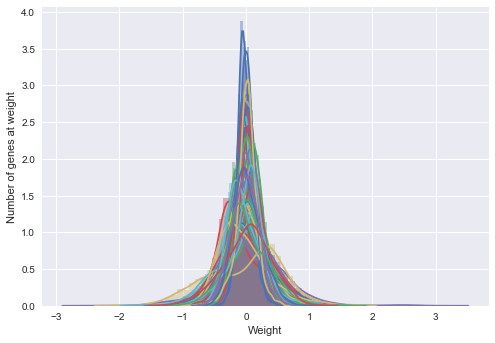

In [9]:
sns.set(color_codes=True)
def plot_feature_weight_distributions(end_feature, dataframe):
    fig, ax = plt.subplots()
    for i in range(0, end_feature):
        sns.distplot(weight_matrix[:,i])
    ax.set_xlabel("Weight")
    ax.set_ylabel("Number of genes at weight")
    plt.show()
plot_feature_weight_distributions(100, weight_matrix)

Like the weight distribution of an ADAGE/eADAGE feature, an NMF feature is approximately normally distributed. Because of this, the gene signature rule we use can be the same as the one used in the ADAGE/eADAGE case (see: [`constants/gene_signature_definitions.py`](https://github.com/kathyxchen/PathCORE-analysis/blob/master/constants/gene_signature_definitions.py))

In [10]:
def define_FastICA_gene_signature(std=2.5):
    def _gene_signature(feature_weight_vector, std):
        mean = feature_weight_vector.mean()
        cutoff = std * feature_weight_vector.std()
        positive_gene_signature = set(
            feature_weight_vector[(feature_weight_vector >=
                                   mean + cutoff)].index)
        negative_gene_signature = set(
                feature_weight_vector[(feature_weight_vector <=
                                       mean - cutoff)].index)
        return positive_gene_signature, negative_gene_signature

    return partial(_gene_signature, std=std)

In [11]:
# load the pathway definitions file as a pandas.DataFrame
pathway_definitions_df = pd.read_table(
    pathways, header=None, names=["pw", "size", "genes"])
pathway_definitions_df["genes"] = pathway_definitions_df["genes"].map(
    lambda x: x.split(";"))
pathway_definitions_df.set_index("pw", inplace=True)

# create a pathway definitions map (key: pathway name, value: set of gene names)
# from the dataframe.
pathway_definitions_map = {}
for index, row in pathway_definitions_df.iterrows():
    pathway_definitions_map[index] = set(row["genes"])

print("Example of a key-value pair in the `pathway_definitions_map` dict:")
print(list(pathway_definitions_map.items())[0])

Example of a key-value pair in the `pathway_definitions_map` dict:
('KEGG-Module-M00718: Multidrug resistance, efflux pump MexAB-OprM', {'PA0424', 'PA4374', 'PA0425', 'PA0426', 'PA4375', 'PA0427'})


### Define a helper function for running the PathCORE analysis workflow
The method `get_pathways_overrepresented_in_features` is a helper function that calls the [`pathway_enrichment_with_overlap_correction`](https://github.com/greenelab/PathCORE/blob/master/pathcore/feature_pathway_overrepresentation.py#L15) method provided in the [pathcore](https://github.com/greenelab/PathCORE) package.
It applies [`pathway_enrichment_with_overlap_correction`](https://github.com/greenelab/PathCORE/blob/master/pathcore/feature_pathway_overrepresentation.py#L15) to every feature in the weight matrix and creates
a pandas.DataFrame of the pathways overrepresented across the entire model (weight matrix of features)
constructed by FastICA on the compendium. 

In [12]:
def get_pathways_overrepresented_in_features(current_weight_matrix, pathway_definitions,
                                             partial_function_signature,
                                             alpha=0.05, correct_all_genes=True,
                                             metadata=False):
    """
    This method is a simplification of the method already provided in the PathCORE-analysis repository.
    See documentation: https://github.com/greenelab/PathCORE-analysis/blob/master/run_network_creation.py#L155
    Modifications:
    * Removed the `overlap_correction` parameter for this example
      - overlap correction will be applied by default.
    * `current_weight_matrix` is just a pandas.DataFrame rather
      than a tuple of a filename and a pandas.DataFrame

    We kept some of the parameters (alpha, correct_all_genes, metadata)
    so that users interested in running the notebook themselves
    could examine differences in results that occurs with parameter
    changes and/or view the metadata that accompanies this analysis.
    """
    n_genes, _ = current_weight_matrix.shape
    significant_pathways_df = pd.DataFrame()
    feature_metadata = {}
    for feature in current_weight_matrix:
        feature_df, additional = \
            pathway_enrichment_with_overlap_correction(
                current_weight_matrix[feature], pathway_definitions,
                partial_function_signature,
                alpha=alpha, correct_all_genes=correct_all_genes,
                metadata=metadata)
        if feature_df is not None:
            feature_df.loc[:, "feature"] = pd.Series(
                [feature] * len(feature_df.index), index=feature_df.index)
            significant_pathways_df = pd.concat(
                [significant_pathways_df, feature_df], axis=0)
            if additional:
                feature_metadata[feature] = additional
    significant_pathways_df.reset_index(drop=True, inplace=True)
    return {"significant_pathways": significant_pathways_df,
            "feature_metadata": feature_metadata}

### PathCORE network creation steps (based on [this script](https://github.com/greenelab/PathCORE-analysis/blob/master/run_network_creation.py))

**Note**: We have not implemented logging for the overlap correction step yet. The print output from calling `get_pathways_overrepresented_in_features` reports that an approximation step is taking place in overlap correction
because numpy is reporting a FloatingPointError when dividing by near-zero probabilities. [An issue has been created](https://github.com/kathyxchen/crosstalk-correction/issues/2) in the overlap correction (crosstalk correction) repository to address this at a later time.

In [13]:
%%time
feature_significant_pathways_info = get_pathways_overrepresented_in_features(
    weight_matrix_df, pathway_definitions_map,
    define_FastICA_gene_signature(gene_signature_std))

129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
118 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
105 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
107 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
129 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
130 adjustments made to a vector of length 186 containing the raw weight values in a call to 'update_probabilities'
132 adjustments made to a vector of length 186 containing the raw weight

In [14]:
# if the `metadata` parameter in `get_pathways_overrepresented_in_features` were set to True,
# the `feature_metadata` key in `feature_significant_pathways_info` would have a non-empty dict value.
print("Keys in output: {0}".format(feature_significant_pathways_info.keys()))
print("The value stored in the `feature_metadata` key: {0}".format(feature_significant_pathways_info["feature_metadata"]))

Keys in output: dict_keys(['significant_pathways', 'feature_metadata'])
The value stored in the `feature_metadata` key: {}


`significant_pathways` is a DataFrame that reports on the pathways significant in each of the NMF features.

In [15]:
significant_pathways = feature_significant_pathways_info["significant_pathways"]
significant_pathways.head()

,p-value,side,q-value,pathway,feature
0,3.487335e-06,pos,6.486444e-04,KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,0.0
1,3.259411e-04,pos,3.031252e-02,KEGG-Module-M00334: Type VI secretion system,0.0
2,4.652635e-20,pos,1.730780e-17,"KEGG-Pathway-pae00280: Valine, leucine and iso...",0.0
3,1.598473e-04,pos,1.982107e-02,KEGG-Pathway-pae00520: Amino sugar and nucleot...,0.0
4,2.227683e-19,neg,8.286979e-17,"KEGG-Module-M00178: Ribosome, bacteria",1.0


We use this information to construct a co-occurrence network by loading it into the CoNetwork constructor.

In [16]:
model_network = CoNetwork(
    n_features, significant_pathways=significant_pathways)

In [17]:
model_network_df = model_network.to_dataframe()
model_network_df[model_network_df.weight > 1]

The pathway co-occurrence network contains 92 pathways.


,pw0,pw1,weight,features
305,"KEGG-Module-M00178: Ribosome, bacteria",KEGG-Pathway-pae03010: Ribosome - Pseudomonas ...,19,1.0 49.0 56.0 66.0 118.0 119.0 120.0 127.0 140...
51,"KEGG-Module-M00178: Ribosome, bacteria",KEGG-Pathway-pae00190: Oxidative phosphorylati...,11,56.0 66.0 118.0 135.0 140.0 146.0 194.0 277.0 ...
87,KEGG-Module-M00334: Type VI secretion system,KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,10,0.0 30.0 36.0 60.0 101.0 114.0 156.0 187.0 196...
402,"KEGG-Pathway-pae00280: Valine, leucine and iso...",KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,10,0.0 47.0 51.0 111.0 112.0 187.0 192.0 196.0 23...
32,"KEGG-Pathway-pae00280: Valine, leucine and iso...",KEGG-Pathway-pae00627: Aminobenzoate degradati...,9,51.0 73.0 104.0 112.0 121.0 163.0 232.0 240.0 ...
299,KEGG-Pathway-pae00190: Oxidative phosphorylati...,KEGG-Pathway-pae03010: Ribosome - Pseudomonas ...,8,56.0 66.0 118.0 140.0 146.0 277.0 285.0 289.0
274,"KEGG-Module-M00009: Citrate cycle (TCA cycle, ...","KEGG-Module-M00178: Ribosome, bacteria",8,1.0 49.0 65.0 119.0 127.0 146.0 214.0 243.0
148,KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,KEGG-Pathway-pae02040: Flagellar assembly - Ps...,8,75.0 79.0 87.0 121.0 161.0 198.0 240.0 270.0
332,"KEGG-Module-M00644: Vanadium resistance, efflu...",KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,7,30.0 36.0 51.0 54.0 90.0 112.0 233.0
232,KEGG-Pathway-pae00460: Cyanoamino acid metabol...,KEGG-Pathway-pae02024: Quorum sensing - Pseudo...,7,35.0 46.0 101.0 112.0 169.0 227.0 233.0


### PathCORE permutation test (based on [this script](https://github.com/greenelab/PathCORE-analysis/blob/master/run_permutation_test.py#L146))
The permutation test is used to evaluate whether each edge observed in the network (see `model_network_df`) at a given weight occurs more than we would expect by chance. By generating `n_permutations` (see cell [23]) of null networks, we can determine the null edge weight distribution of each observed edge. Edges that are insignificant under the null distribution are discarded from the network. 

Significance is determined by collecting the p-values of every observed edge and applying a false discovery rate correction (Benjamini--Hochberg) to that list of p-values. Edges with a q-value below the specified alpha (`permutation_test_alpha` in cell [23]) are significant.

In [18]:
%%time
permutations = []
for i in range(n_permutations):
    # `aggregate_permutated_network` takes in a list of networks right now.
    # adjusting the `random_state` parameter in FastICA would allow us to
    # generate multiple networks from different ICA models, adding an extra
    # stability assessment for the pathway-pathway relationships identified.
    permutations.append(aggregate_permuted_network([model_network]))

Wall time: 1min 57s


In [19]:
final_network = network_edges_permutation_test(
    model_network, permutations, permutation_test_alpha,
    n_networks=1)

67 edges are significant under the null distribution, generated from 1000 permutations, for alpha = 0.05.


Edges in the network after the permutation test are weighted by their **odds ratios**. The odds ratio is computed by dividing the observed edge weight by the expected edge weight (the average of its non-zero edge weight distribution). If the observed edge does not show up in any of the permuted networks, divide by 1 (no change).

In [20]:
significant_edges = []
for edge_id, edge_obj in final_network.edges.items():
    if edge_obj.significant:
        pw0, pw1 = final_network.get_edge_pathways(edge_id)
        significant_edges.append({"pw0": pw0, "pw1": pw1, "odds ratio": edge_obj.weight})
significant_edges_df = pd.DataFrame(significant_edges)
significant_edges_df.sort_values("odds ratio", ascending=False)
significant_edges_df

,odds ratio,pw0,pw1
0,2.645963,"KEGG-Module-M00011: Citrate cycle, second carb...","KEGG-Module-M00178: Ribosome, bacteria"
1,3.189286,KEGG-Module-M00334: Type VI secretion system,"KEGG-Pathway-pae00280: Valine, leucine and iso..."
2,3.457074,KEGG-Pathway-pae00520: Amino sugar and nucleot...,KEGG-Pathway-pae02040: Flagellar assembly - Ps...
3,2.674699,"KEGG-Module-M00835: Pyocyanine biosynthesis, c...","KEGG-Pathway-pae00280: Valine, leucine and iso..."
4,6.725365,"KEGG-Pathway-pae00280: Valine, leucine and iso...",KEGG-Pathway-pae00627: Aminobenzoate degradati...
5,2.629325,"KEGG-Module-M00644: Vanadium resistance, efflu...","KEGG-Pathway-pae00280: Valine, leucine and iso..."
6,3.373424,"KEGG-Module-M00178: Ribosome, bacteria",KEGG-Pathway-pae00190: Oxidative phosphorylati...
7,3.000000,KEGG-Module-M00208: Glycine betaine/proline tr...,"KEGG-Pathway-pae00260: Glycine, serine and thr..."
8,2.964706,KEGG-Module-M00324: Dipeptide transport system,KEGG-Pathway-pae00640: Propanoate metabolism -...
9,1.000000,KEGG-Module-M00048: Inosine monophosphate bios...,"KEGG-Module-M00769: Multidrug resistance, effl..."
